In [1]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.11.0


In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = (150, 150)

tf.random.set_seed(0)

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


In [4]:
for dirname, _, filenames in os.walk('Documents/breast_ultrasound_images'):
    print(dirname)

Documents/breast_ultrasound_images
Documents/breast_ultrasound_images\seg_pred
Documents/breast_ultrasound_images\seg_test
Documents/breast_ultrasound_images\seg_test\benign
Documents/breast_ultrasound_images\seg_test\malignant
Documents/breast_ultrasound_images\seg_test\normal
Documents/breast_ultrasound_images\seg_train
Documents/breast_ultrasound_images\seg_train\benign
Documents/breast_ultrasound_images\seg_train\malignant
Documents/breast_ultrasound_images\seg_train\normal


In [5]:
CLASSES = {'benign': 0, 'malignant': 1, 'normal': 2}

In [6]:
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=42)
    df.reset_index(drop=True, inplace=True)
    df = df[ : df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

In [7]:
filenames = tf.io.gfile.glob('Documents/breast_ultrasound_images/seg_train/*/*')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('\\')[-2] for x in filenames]})
image_path_df_train = shuffle_prune(image_path_df_train, BATCH_SIZE)
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)
print('Train sample: ', len(image_path_df_train['class']),dict(image_path_df_train['class'].value_counts()))

Train sample:  1600 {1: 541, 2: 532, 0: 527}


In [8]:
filenames = tf.io.gfile.glob('Documents/breast_ultrasound_images/seg_test/*/*')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('\\')[-2] for x in filenames]})

print('Test sample: ', len(image_path_df_test['class']),dict(image_path_df_test['class'].value_counts()))

Test sample:  399 {'benign': 133, 'malignant': 133, 'normal': 133}


In [9]:
image_path_df_test, image_path_df_val  = train_test_split(image_path_df_test, test_size=0.5, random_state=42, stratify=image_path_df_test['class'])
image_path_df_test = shuffle_prune(image_path_df_test, BATCH_SIZE)
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_val = shuffle_prune(image_path_df_val, BATCH_SIZE)
image_path_df_val['class'] = image_path_df_val['class'].map(CLASSES)

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))
print('Val  sample: ', len(image_path_df_val['class']), dict(image_path_df_val['class'].value_counts()))

Test sample:  192 {0: 66, 2: 64, 1: 62}
Val  sample:  192 {1: 67, 0: 63, 2: 62}


In [10]:
filenames = tf.io.gfile.glob('Documents/breast_ultrasound_images/seg_pred/*')
image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')

Number filenames: 61


In [11]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels

In [12]:
val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')

Shape of validation set: (192, 150, 150, 3)
Shape of validation set: (192,)


In [13]:
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')

Shape of test set: (192, 150, 150, 3)
Shape of test set: (192,)


In [14]:
train_images, train_labels=get_images_and_labels_arrays(image_path_df_train)
print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')

Shape of train set: (1600, 150, 150, 3)
Shape of train set: (1600,)


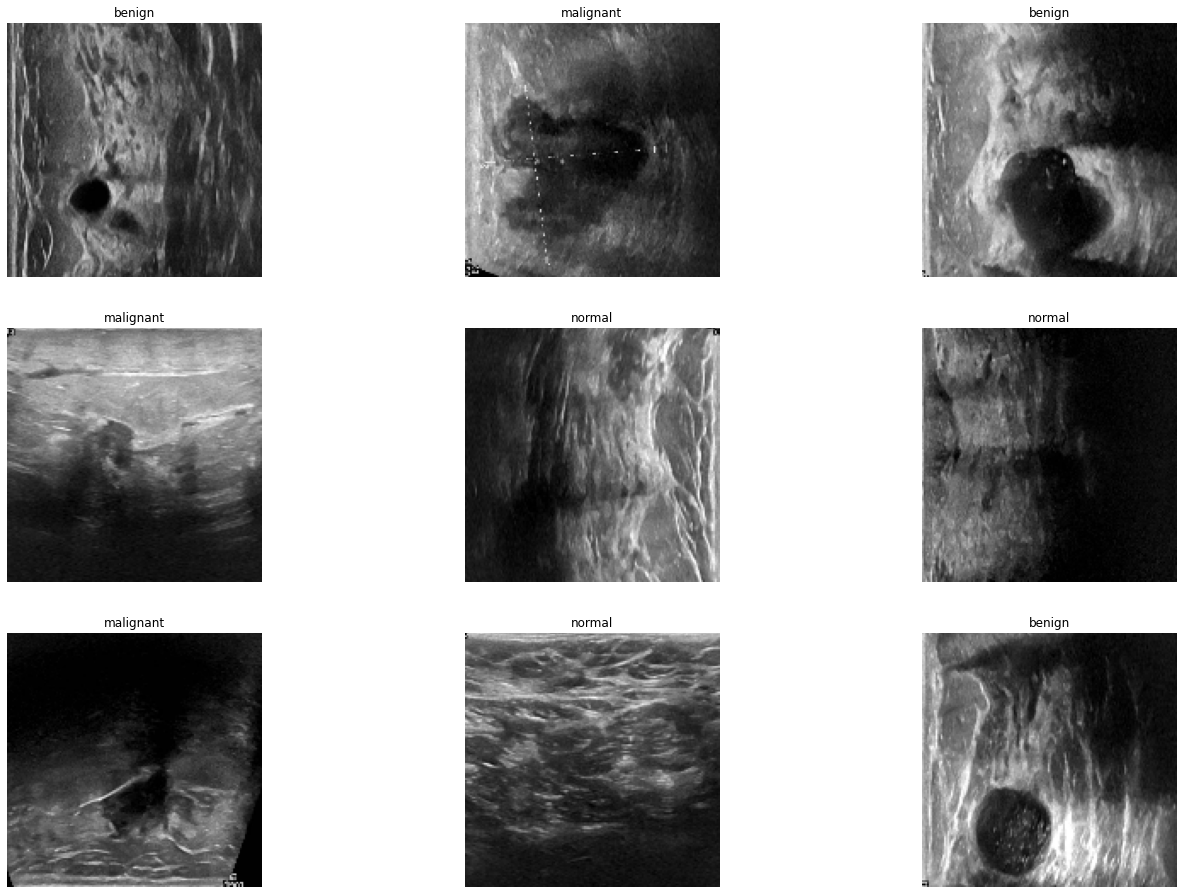

In [15]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == train_labels[rnd_number]][0])
        ax[i,j].axis('off')

In [16]:
def create_model():
    
    with tf.device('/gpu:0'):
    
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        x = layers.BatchNormalization()(input_layer)

        x = layers.Conv2D(filters=64, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
        x = layers.Dropout(0.1, name='dropout_1')(x)

        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
        x = layers.Dropout(0.1, name='dropout_2')(x)

        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
        x = layers.Dropout(0.1, name='dropout_3')(x)
        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
        x = layers.Dropout(0.1, name='dropout_4')(x)

        x = layers.Conv2D(filters=1024, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
        x = layers.Dropout(0.1, name='dropout_5')(x)
        

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)
       
        x = layers.Dense(128,activation='relu')(x)
        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
from tensorflow.keras.models import save_model

# Assuming your model variable is named 'model'
save_model(model, 'Documents/modelfb.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 128)       73856     
                                                             

In [17]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/10
50/50 [==============================] - 188s 4s/step - loss: 1.3424 - accuracy: 0.3169 - val_loss: 2.7865 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 180s 4s/step - loss: 1.0658 - accuracy: 0.2937 - val_loss: 2.8870 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.9332 - accuracy: 0.3256
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
50/50 [==============================] - 176s 4s/step - loss: 0.9332 - accuracy: 0.3256 - val_loss: 0.8831 - val_accuracy: 0.1823 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.3300
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
50/50 [==============================] - 176s 4s/step - loss: 0.6728 - accuracy: 0.3300 - val_loss: 0.9036 - val_accuracy: 0.1042 - lr: 3.0000e-04
Epoch 5/10
50/50 [==============================] - ETA: 0s - 

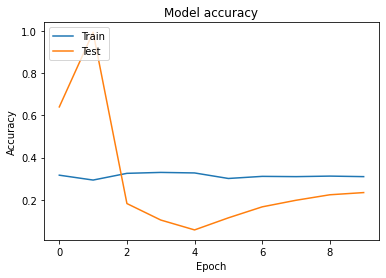

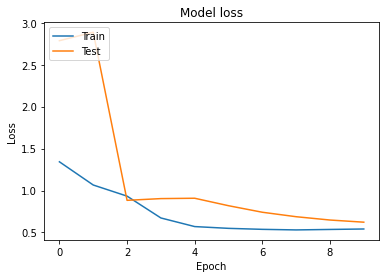

In [18]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.2135416716337204   loss:  0.6479448676109314


In [20]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

6/6 [==============================] - 4s 574ms/step


array([2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 0,
       0, 2, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 2, 1, 2,
       0, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2,
       1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 2, 2, 0, 0,
       1, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2,
       1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 2, 0, 1, 2, 1], dtype=int64)

              precision    recall  f1-score   support

           0       0.98      0.61      0.75        66
           1       0.67      0.81      0.73        62
           2       0.70      0.83      0.76        64

    accuracy                           0.74       192
   macro avg       0.78      0.75      0.74       192
weighted avg       0.78      0.74      0.75       192
 



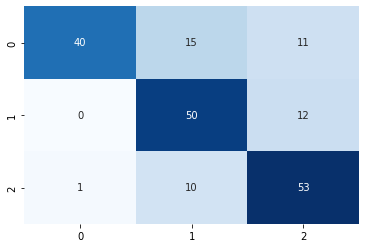

In [21]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

In [22]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        
        
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        
        x = pretrained_model(input_layer)

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)       
        x = layers.Dense(128,activation='relu')(x)

        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)
        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

model = create_model()
from tensorflow.keras.models import save_model

# Assuming your model variable is named 'model'
save_model(model, 'Documents/modelfb1.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 150, 150, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 output (Dense)              (None, 3)                 387 

In [23]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/10
50/50 [==============================] - 160s 3s/step - loss: 0.7489 - accuracy: 0.3094 - val_loss: 0.8644 - val_accuracy: 0.6198 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.3899 - accuracy: 0.3019
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
50/50 [==============================] - 156s 3s/step - loss: 0.3899 - accuracy: 0.3019 - val_loss: 0.3664 - val_accuracy: 0.3646 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.3200
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
50/50 [==============================] - 137s 3s/step - loss: 0.2830 - accuracy: 0.3200 - val_loss: 0.2987 - val_accuracy: 0.3385 - lr: 3.0000e-04
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.3175
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
50/50 [==============================] - 130s 

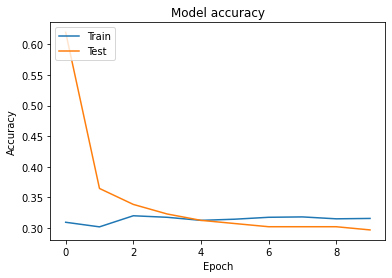

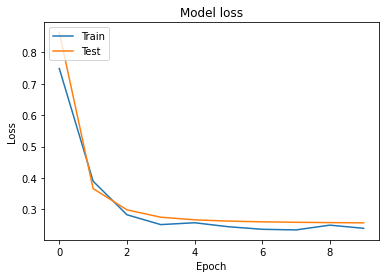

In [24]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.34375   loss:  0.26980268955230713


In [26]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

6/6 [==============================] - 17s 3s/step


array([0, 0, 2, 2, 1, 1, 0, 1, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2,
       2, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 2, 2, 1, 0, 0, 1, 1, 0, 0, 0, 2,
       0, 0, 0, 1, 2, 1, 0, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 0, 2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 0, 0,
       2, 2, 1, 0, 1, 1, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 2,
       2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 1, 2, 0, 1, 0, 1], dtype=int64)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        66
           1       1.00      0.89      0.94        62
           2       0.87      0.97      0.92        64

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted avg       0.93      0.93      0.93       192
 



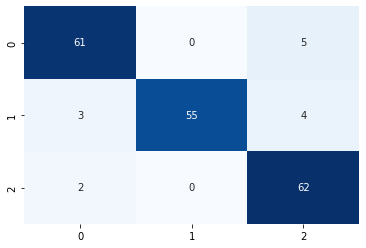

In [27]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

In [28]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)
print(f'Shape of images set to prediction: {to_predict_images.shape}')

Shape of images set to prediction: (61, 150, 150, 3)


In [29]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

2/2 [==============================] - 6s 2s/step


array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2,
       0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1], dtype=int64)

IndexError: index 61 is out of bounds for axis 0 with size 61

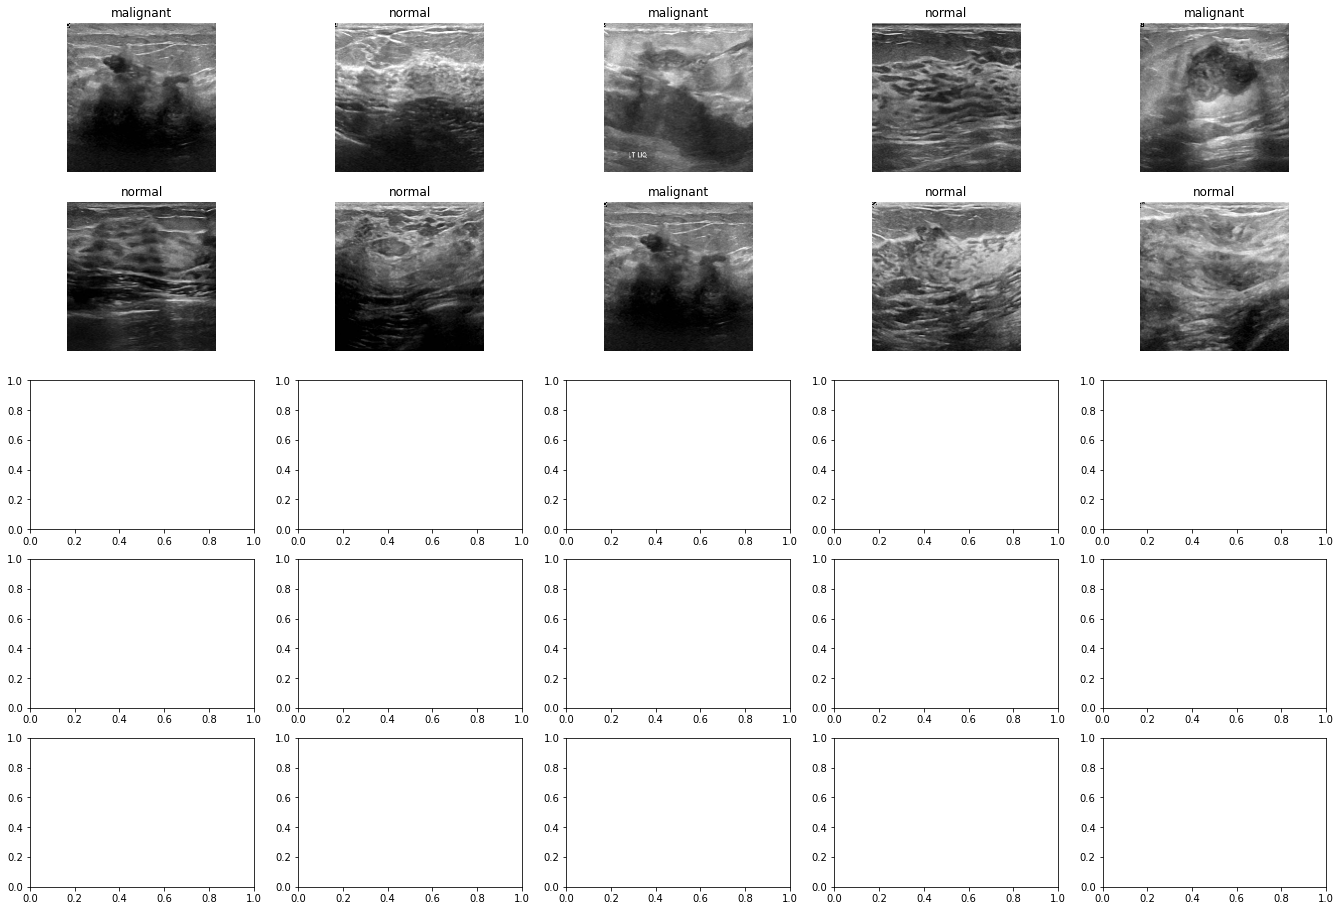

In [30]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(predict))
        ax[i,j].imshow(to_predict_images[rnd_number])
        #ax[i,j].imshow(test_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items()  if val == predict[rnd_number]][0])
        #print(os.path.basename(f))
        ax[i,j].axis('off')

In [31]:
import numpy as np
import tensorflow as tf

# Load your trained model
#model = tf.keras.models.load_model('model.h5')

# Load the test images and labels
#test_images = ...  your test images
#test_labels = ... # the actual labels for the test images
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

# Make predictions for the test images
predictions = model.predict(val_images)

# Convert the predictions to the class labels
to_predict_labels = np.argmax(predictions, axis=1)
#f,ax=plt.subplots(3,3)
# Compare the actual and predicted labels
for i in range(len(val_images)):
    #for j in range(0,3,1):
        #for k in range(0,3,1):
            #ax[j,k].imshow(to_predict_images[i])
    print("Image {}: Actual label = {}, Predicted label = {}".format(i, val_labels[i],to_predict_labels[i]))
            #ax[j,k].imshow(test_images[i])

6/6 [==============================] - 12s 2s/step
Image 0: Actual label = 0, Predicted label = 0
Image 1: Actual label = 1, Predicted label = 1
Image 2: Actual label = 1, Predicted label = 1
Image 3: Actual label = 2, Predicted label = 2
Image 4: Actual label = 2, Predicted label = 2
Image 5: Actual label = 0, Predicted label = 1
Image 6: Actual label = 2, Predicted label = 2
Image 7: Actual label = 0, Predicted label = 0
Image 8: Actual label = 2, Predicted label = 2
Image 9: Actual label = 0, Predicted label = 0
Image 10: Actual label = 2, Predicted label = 2
Image 11: Actual label = 0, Predicted label = 0
Image 12: Actual label = 2, Predicted label = 2
Image 13: Actual label = 0, Predicted label = 0
Image 14: Actual label = 0, Predicted label = 0
Image 15: Actual label = 2, Predicted label = 2
Image 16: Actual label = 2, Predicted label = 2
Image 17: Actual label = 1, Predicted label = 1
Image 18: Actual label = 2, Predicted label = 2
Image 19: Actual label = 0, Predicted label = 0

In [36]:
import torch
# torch.save(model.state_dict(),'breast_cancer_model.pth')
save_model(model,'Documents/breast_cancer_model.h5')